In [27]:
#imports
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from tabulate import tabulate
import xarray as xr
import dask

import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import ticker
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from mpl_toolkits.basemap import Basemap
bm = Basemap()

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


In [38]:
pkl_file = open('/fast/gmooers/Preprocessed_Data/CAM5_Diurnal.pkl', 'rb')
data1 = pickle.load(pkl_file)
pkl_file.close()

(96, 144)


In [28]:
path_to_file = "/fast/gmooers/Preprocessed_Data/PRECT_JJA_rcat.nc"
ds = xr.open_dataset(path_to_file)
cams = ds.PRECT.values

dataset = netCDF4.Dataset("/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h1.2009-01-01-00000.nc")
lons = np.array(dataset.variables['lon'])
lats = np.array(dataset.variables['lat'])

In [29]:
ny = lats.size
nx = lons.size
nday = int(len(cams)/96)
nperday = 96


#Make an empty array of 0's by days, samples in a day, at each lat/lon coord
cam_data_reorganized = np.zeros(shape=(nday, nperday, ny, nx))

#loop over the number of days
count = 0
for i in range(len(cam_data_reorganized)):
    #loop over the samples per day
    for j in range(len(cam_data_reorganized[0])):
        cam_input_array = np.squeeze(cams[count , :, :])
        cam_data_reorganized[i, j, :, :] = cam_input_array
        count = count+1

In [30]:
cam_themean = np.nanmean(cam_data_reorganized, axis = 0)
cam_thestd = np.nanstd(cam_data_reorganized, axis = 0)

cam_amplitude_map = np.zeros(shape=(ny, nx))
cam_phase_map_utc = np.zeros(shape=(ny, nx))
cam_phase_map_lst = np.zeros(shape=(ny, nx))


#get times into UTC
dataset = netCDF4.Dataset("/fast/gmooers/Preprocessed_Data/PRECT_MAPS_rcat.nc")
#!ncdump -h FLUT_JJA_rcat.nc

t = np.array(dataset.variables['time'])
utc_hour = (t[:96] - math.floor(t[0]))*24.0-0.125
utc_hour[0] = utc_hour[0]+24

In [31]:
#loop through longitudes
for i in range(len(cam_data_reorganized[0][0][0])):
    lst_hour = utc_hour +(lons[i]/360.)*24.
    lst_hour[lst_hour > 24] = lst_hour[lst_hour > 24] - 24
    
    #loop through latitudes
    for j in range(len(cam_data_reorganized[0][0])):
        cam_precip_cycle = np.squeeze(cam_themean[:, j, i])
        cam_amplitude_here = max(cam_precip_cycle)-min(cam_precip_cycle)
        cam_stderr_here = np.squeeze(max(cam_thestd[:,j,i]))/(math.sqrt(nday/4.0-1.0))
        
        if cam_amplitude_here >= 2.0*cam_stderr_here:
            cam_amplitude_map[j, i] = cam_amplitude_here
            #at what hour did max occur?
            if np.std(cam_precip_cycle) > 0.0:
                #b = max(precip_cycle)
                #index_max = np.where(precip_cycle = b)
                index_max = np.argmax(cam_precip_cycle)
                cam_phase_map_utc[j, i] = utc_hour[index_max]
                cam_phase_map_lst[j, i] = lst_hour[index_max]

In [32]:
cam_nan_map_utc = cam_phase_map_utc 
cam_nan_map_lst = cam_phase_map_lst
for i in range(len(cam_phase_map_utc)):
    for j in range(len(cam_phase_map_utc[i])):
        if cam_phase_map_utc[i][j] == 0.0:
            cam_nan_map_utc[i][j] = np.nan
            cam_nan_map_lst[i][j] = np.nan

In [33]:
Xvar, Yvar = np.meshgrid(lons, lats)

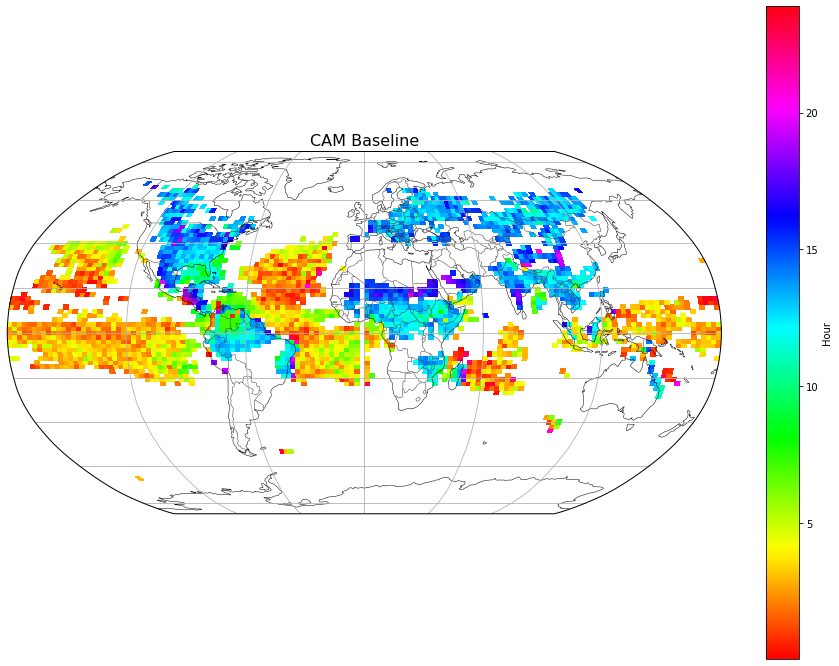

In [39]:
fig, ax1 = plt.subplots(1,1,subplot_kw={'projection':ccrs.Robinson()})
fig.set_size_inches(16,12)

contour_plot = ax1.pcolormesh(lons,lats, data1,cmap='hsv', transform=ccrs.PlateCarree())
plt.colorbar(contour_plot, label = 'Hour')
ax1.set_title('CAM Baseline')
ax1.title.set_fontsize(16)
ax1.coastlines(linewidth=0.5,edgecolor='0.25')
ax1.gridlines()
ax1.add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
#plt.savefig("/oasis/scratch/comet/gmooers/temp_project/SCRIPTS/Figures/Good_Summer_Precip.png")

In [40]:
#np.save("/fast/gmooers/RG_Paper_Data/Summer_Precip_Cycle_CAM.npy",data1)